# VSD Data Visualization Notebook

This notebook demonstrates the visualization capabilities for VSD (Voltage-Sensitive Dye) video data, including:
- Frame sequence visualization
- Spatial dynamics analysis

## Setup and Imports


In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
!rm -rf VSD_foundation_model
!git clone --branch None_to_null https://github.com/ossnat/VSD_foundation_model.git
!ln -s '/content/drive/My Drive/VSD_FM/Data' '/content'

Cloning into 'VSD_foundation_model'...
remote: Enumerating objects: 546, done.
remote: Counting objects: 100% (225/225), done.
remote: Compressing objects: 100% (151/151), done.
remote: Total 546 (delta 127), reused 129 (delta 69), pack-reused 321 (from 1)
Receiving objects: 100% (546/546), 3.82 MiB | 21.40 MiB/s, done.
Resolving deltas: 100% (306/306), done.
ln: failed to create symbolic link '/content/Data': File exists


In [41]:
import os
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import h5py

# Ensure project root is on sys.path for imports
project_root = Path('VSD_foundation_model')
sys.path.insert(0, str(project_root))

# Import project modules
from src.data.data_loader import load_dataset
from src.utils.visualization import plot_frames_sequence, plot_spatial_dynamics

print("Imports completed successfully!")


Imports completed successfully!


## Configuration

Set up the data path and visualization parameters:


In [42]:
# !cd '/content'

In [80]:
# Data configuration
DATA_DIR = Path(r"Data/FoundationData/ProcessedData")

# Visualization parameters
MONKEY = "frodo"
FRAME_START = 27
FRAME_END = 68
CLIPPING_RANGE = (1-0.0005, 1.0005)
GRID_ROWS = 10
GRID_COLS = 10

monkey_dir = DATA_DIR / MONKEY
print(f"Data path: {monkey_dir} (for monkey: {MONKEY})")
print(f"Frame range: {FRAME_START} - {FRAME_END}")
print(f"Grid layout: {GRID_ROWS}×{GRID_COLS}")

# List all subfolders in monkey_dir
print("Subfolders in monkey_dir:")
for item in os.listdir(monkey_dir):
    item_path = monkey_dir / item
    print(f"  - {item}")

Data path: Data/FoundationData/ProcessedData/frodo (for monkey: frodo)
Frame range: 27 - 68
Grid layout: 10×10
Subfolders in monkey_dir:
  - session_021209a_condsAN.h5
  - session_021209c_condsAN.h5
  - session_021209d_condsAN.h5
  - session_021209e_condsAN.h5
  - session_021209f_condsAN.h5
  - session_071009a_condsAN.h5
  - session_071009b_condsAN.h5
  - session_071009c_condsAN.h5
  - session_071009d_condsAN.h5
  - session_071009e_condsAN.h5
  - session_091209a_condsAN.h5
  - session_091209g_condsAN.h5
  - session_091209h_condsAN.h5
  - session_141009c_condsAN.h5
  - session_141009d_condsAN.h5
  - session_141009e_condsAN.h5
  - session_141009f_condsAN.h5
  - session_141009g_condsAN.h5
  - session_141009h_condsAN.h5
  - session_141009k_condsAN.h5
  - session_160909c_condsAN.h5
  - session_160909d_condsAN.h5
  - session_160909e_condsAN.h5
  - session_160909f_condsAN.h5
  - session_160909g_condsAN.h5
  - session_230909a_condsAN.h5
  - session_230909b_condsAN.h5
  - session_230909c_condsA

## Data Loading and Inspection

In [83]:
print(f"Content of {HDF5_FILE_PATH}:")
with h5py.File(HDF5_FILE_PATH, 'r') as f:
    print(f.keys())

Content of Data/FoundationData/ProcessedData/frodo/session_091209h_condsAN.h5:
<KeysViewHDF5 ['trial_000000', 'trial_000001', 'trial_000002', 'trial_000003', 'trial_000004', 'trial_000005', 'trial_000006', 'trial_000007', 'trial_000008', 'trial_000009', 'trial_000010', 'trial_000011', 'trial_000012', 'trial_000013', 'trial_000014', 'trial_000015', 'trial_000016', 'trial_000017', 'trial_000018', 'trial_000019', 'trial_000020', 'trial_000021', 'trial_000022', 'trial_000023', 'trial_000024', 'trial_000025']>


In [84]:
# User inputs for specific trial selection
SESSION_FILENAME = "session_091209h_condsAN.h5"  # Choose from the listed .h5 files above (e.g., session_100718a_condsAN.h5)
TRIAL_ID = 'trial_000001'  # Index of the trial within the selected condition (0-indexed)
HDF5_FILE_PATH = monkey_dir / SESSION_FILENAME

print(f"Content of {HDF5_FILE_PATH}:")
with h5py.File(HDF5_FILE_PATH, 'r') as f:
    trial = f[TRIAL_ID]
    print(f"Raw trial dataset: {trial}")
    print(f"Raw trial attributes: {trial.attrs}")

    # Convert to numpy array
    trial_np = trial[:, 1:100] # This loads the entire dataset into memory as a numpy array

    # The dataset shape is (10000, 256) which corresponds to (pixels, frames)
    num_pixels, num_frames = trial_np.shape

    # Reshape to (height, width, frames)
    reshaped_trial = trial_np.reshape(100, 100, num_frames)

    # Convert to tensor and reorder dimensions to (batch, frames, height, width)
    # unsqueeze(0) adds a batch dimension
    # permute(0, 3, 1, 2) changes (batch, height, width, frames) to (batch, frames, height, width)
    trial_tensor = torch.from_numpy(reshaped_trial).unsqueeze(0).permute(0, 3, 1, 2)

    print(f"\nTrial converted to tensor:")
    print(f"  Shape: {trial_tensor.shape}")
    print(f"  Dtype: {trial_tensor.dtype}")
    print(f"  Min value: {trial_tensor.min():.4f}")
    print(f"  Max value: {trial_tensor.max():.4f}")
    print(f"  Mean value: {trial_tensor.mean():.4f}")
    print(f"  Median value: {trial_tensor.median():.4f}")

Content of Data/FoundationData/ProcessedData/frodo/session_091209h_condsAN.h5:
Raw trial dataset: <HDF5 dataset "trial_000001": shape (10000, 256), type "<f4">
Raw trial attributes: <Attributes of HDF5 object at 132373985634768>

Trial converted to tensor:
  Shape: torch.Size([1, 99, 100, 100])
  Dtype: torch.float32
  Min value: 0.9463
  Max value: 1.0450
  Mean value: 0.9998
  Median value: 0.9999


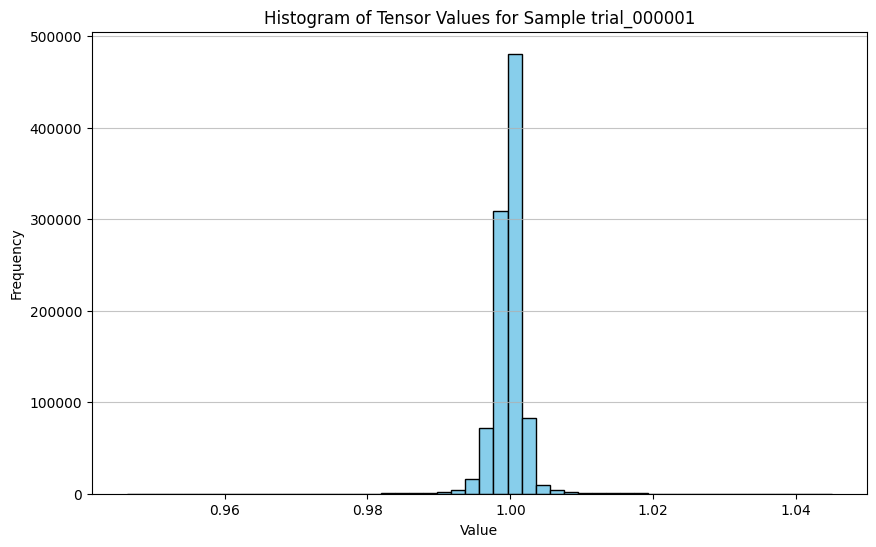

In [85]:
plt.figure(figsize=(10, 6))
plt.hist(trial_tensor.flatten().cpu().numpy(), bins=50, color='skyblue', edgecolor='black')
plt.title(f'Histogram of Tensor Values for Sample {TRIAL_ID}')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

## Frame Sequence Visualization

Visualize a sequence of frames from the selected sample:


Plotting frame sequence for sample trial_000001...


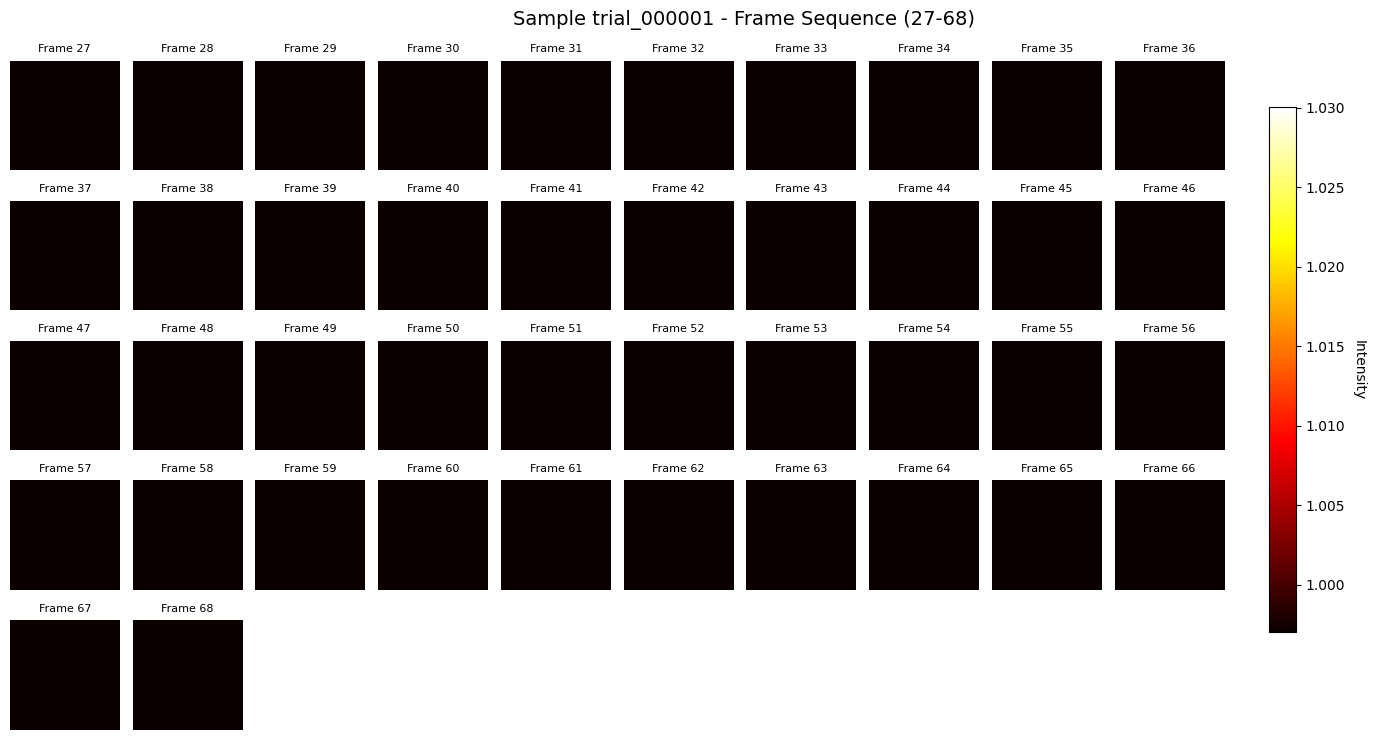

Frame sequence visualization completed!


In [88]:
# Plot frame sequence
print(f"Plotting frame sequence for sample {TRIAL_ID}...")

fig_frames = plot_frames_sequence(
    video_tensor=trial_tensor,
    start_frame=FRAME_START,
    end_frame=FRAME_END,
    clipping=(1-0.003, 1.03),
    cols=10,
    title=f"Sample {TRIAL_ID} - Frame Sequence ({FRAME_START}-{FRAME_END})",
    show_plot=True
)

print("Frame sequence visualization completed!")


## Spatial Dynamics Analysis

Analyze the spatial dynamics by showing temporal patterns across different spatial regions:


Plotting spatial dynamics for sample trial_000001...


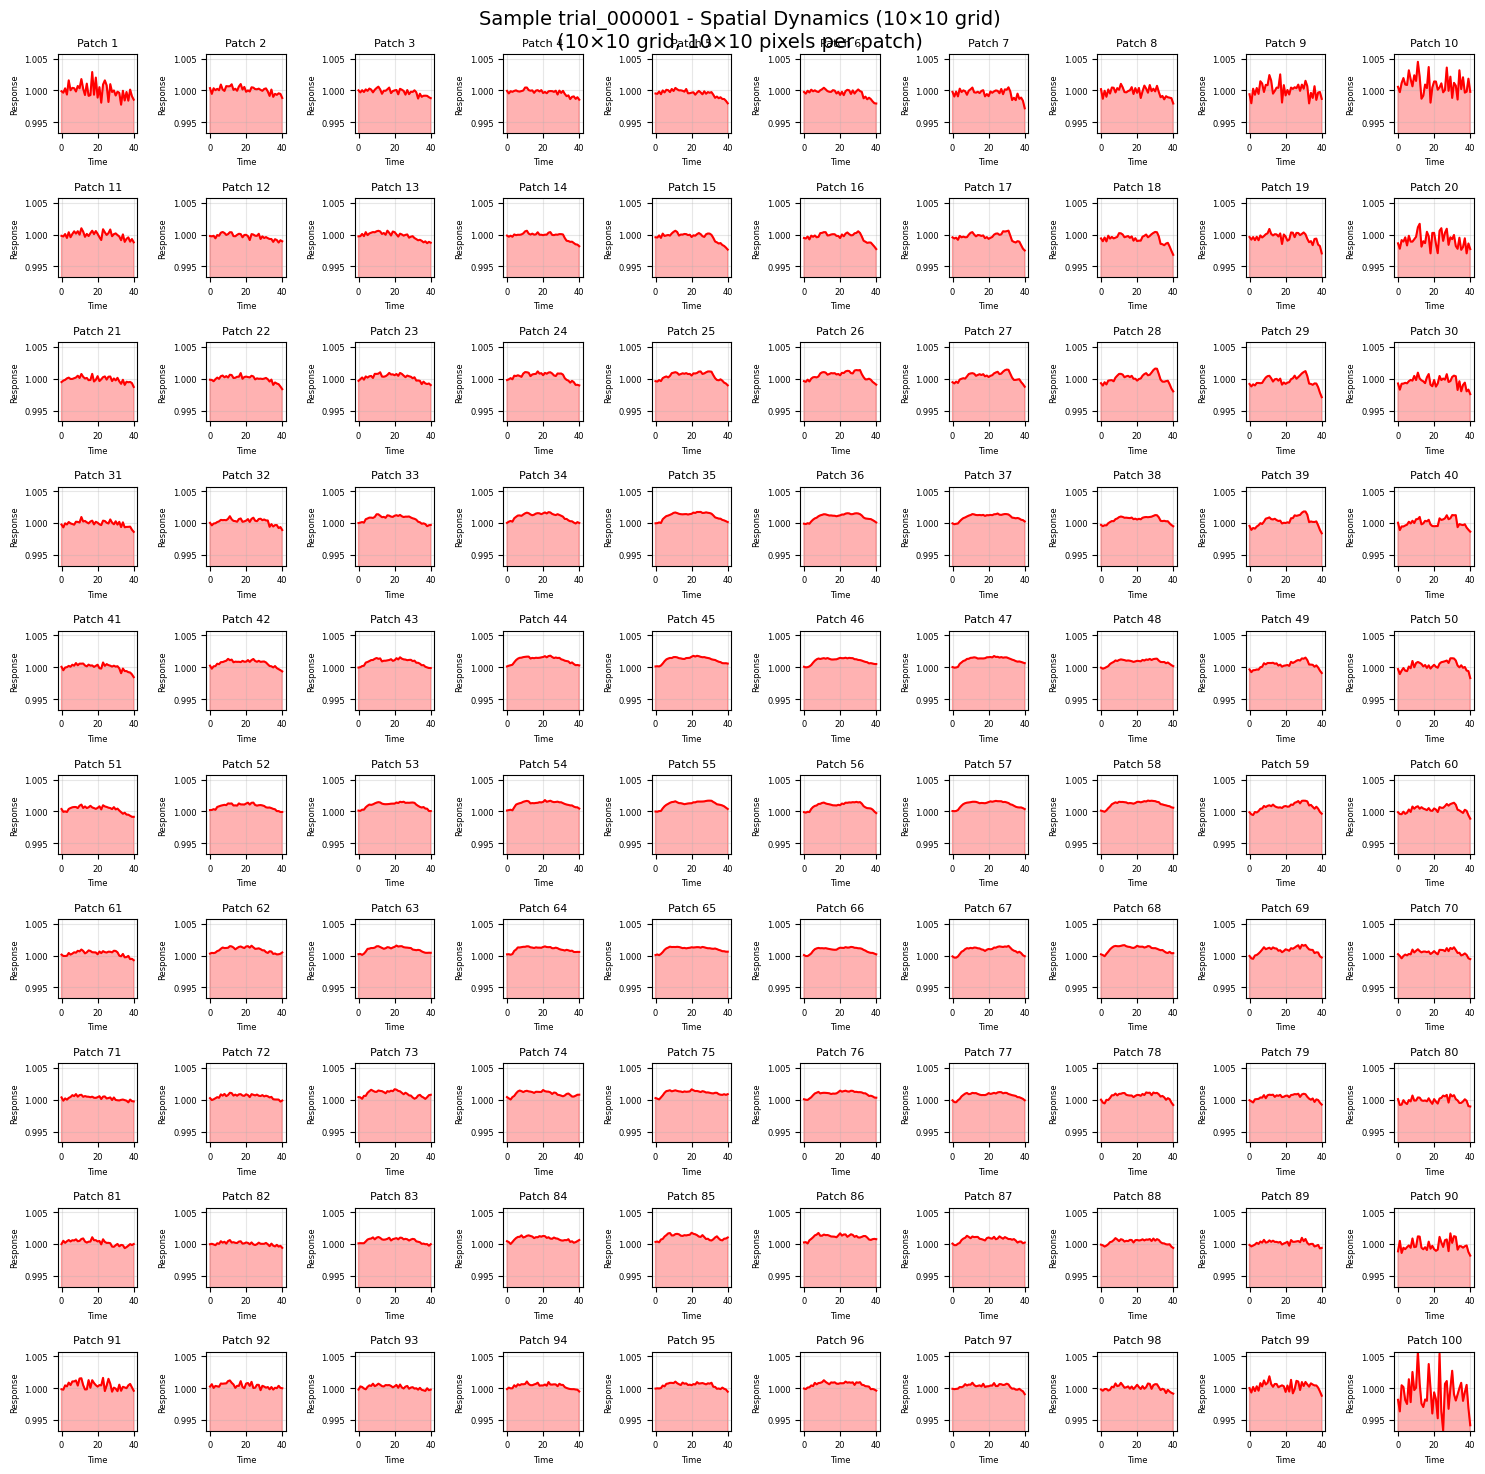

Spatial dynamics visualization completed!


In [89]:
# Plot spatial dynamics
print(f"Plotting spatial dynamics for sample {TRIAL_ID}...")

fig_dynamics = plot_spatial_dynamics(
    video_tensor=trial_tensor[:,FRAME_START:FRAME_END,:,:],
    grid_rows=GRID_ROWS,
    grid_cols=GRID_COLS,
    title=f"Sample {TRIAL_ID} - Spatial Dynamics ({GRID_ROWS}×{GRID_COLS} grid)",
    show_plot=True
    )

print("Spatial dynamics visualization completed!")
